In [1]:
import matplotlib.pyplot as plt
import random
import torch
import numpy as np
import pandas as pd
import os
from sklearn.manifold import TSNE
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel, DataCollatorForLanguageModeling
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import WhitespaceSplit
from tokenizers.trainers import WordLevelTrainer

class TokenizeDataset:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def tokenize(self, data):
        return self.tokenizer(
            data["text"],
            truncation=True,
            padding=True,
            max_length=2048,
        )

    def batch_tokenization(self, dataset):
        dataset_tokenized = dataset.map(
            self.tokenize, batched=True, remove_columns=["text"]
        )
        return dataset_tokenized


def train_tokenizer(model_path, train_data, verbose=True):
    tokenizer_path = f"{model_path}/tokenizer.json"
    if not os.path.isfile(tokenizer_path):
        tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
        tokenizer.pre_tokenizer = WhitespaceSplit()
        tokenizer_trainer = WordLevelTrainer(
            special_tokens=["[UNK]", "[PAD]", "[MASK]"]
        )
        tokenizer.train_from_iterator(train_data["text"], trainer=tokenizer_trainer)
        tokenizer.save(tokenizer_path)

    tokenizer = PreTrainedTokenizerFast(tokenizer_file=tokenizer_path)
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})
    print("Vocabulary size: ", tokenizer.vocab_size)
    if verbose:
        print("Vocabulary:")
        [print(voc) for voc in sorted(tokenizer.vocab.items())]

    return tokenizer


def check_tokenized_data(dataset, tokenized_dataset, plot_path=False):
    assert "input_ids" in list(tokenized_dataset[0]), list(tokenized_dataset[0])
    for i, data in enumerate(dataset["text"][:100:20]):
        print("----")
        print(data)
        print(tokenized_dataset[i]["input_ids"])
    if plot_path != False:
        inst_tokens = []
        for data in dataset["text"]:
            inst_tokens += [
                token.strip("INST=") for token in data.split(" ") if "INST=" in token
            ]
        token_occ = np.array(
            [[token, int(inst_tokens.count(token))] for token in np.unique(inst_tokens)]
        ).T
        sorted_occurences = np.sort(token_occ[1].astype(int))
        sorted_tokens = [
            token_occ[0][idx] for idx in np.argsort(token_occ[1].astype(int))
        ]
        plt.plot(sorted_occurences, color="Black")
        plt.xticks(ticks=range(len(sorted_tokens)), labels=sorted_tokens, rotation=45)
        plt.title("Distribution of instrument tokens in dataset")
        plt.xlabel("Instrument tokens")
        plt.ylabel("Count")
        plt.savefig(f"{plot_path}/_token_distribution_in_dataset.png")
        plt.show()
        plt.close()


def get_history(trainer):
    history = trainer.state.log_history
    train_history = []
    valid_history = []
    for h in history:
        if len(h.items()) == 4:
            train_history.append([h["epoch"], h["step"], h["loss"], h["learning_rate"]])
        elif len(h.items()) == 6:
            valid_history.append([h["epoch"], h["step"], h["eval_loss"]])

    history = {
        "train_epoch": np.array(train_history).T[0],
        "train_loss": np.array(train_history).T[2],
        "learning_rate": np.array(train_history).T[3],
        "valid_epoch": np.array(valid_history).T[0],
        "valid_loss": np.array(valid_history).T[2],
    }
    return history


def plot_history(history, model_path, hf_repo):
    plt.subplots(figsize=(10, 10))
    plt.subplot(211)
    plt.plot(history["train_epoch"], history["learning_rate"], color="black")
    plt.xlabel("epochs")
    plt.ylabel("learning rate")
    plt.title(hf_repo)

    plt.subplot(212)
    plt.plot(
        history["train_epoch"],
        history["train_loss"],
        color="purple",
        label="training loss",
    )
    plt.plot(
        history["valid_epoch"],
        history["valid_loss"],
        color="orange",
        label="validation loss",
    )
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("loss")

    plt.savefig(f"{model_path}/training_history.png")
    plt.show()
    plt.close()


In [2]:
path_dataset = "/Users/jean/WORK/DSR_2022_b32/music_portfolio/huggingface_models_and_datasets/datasets/elec-gmusic-familized"
path_model ="/Users/jean/WORK/DSR_2022_b32/music_portfolio/huggingface_models_and_datasets/models/elec-gmusic-familized-model-13-12__17-35-53"

data = load_dataset(
    path_dataset,
    data_files={"train": "train/*.zip", "eval": "validate/*.zip"}
)
tokenizer = train_tokenizer(path_model, data["train"], verbose=False)
data_tokenized = TokenizeDataset(tokenizer).batch_tokenization(data["eval"])
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False, return_tensors="pt")
model = GPT2LMHeadModel.from_pretrained(path_model, output_attentions=True)

Using custom data configuration elec-gmusic-familized-bca602cfa0b7bc03
Found cached dataset text (/Users/jean/.cache/huggingface/datasets/text/elec-gmusic-familized-bca602cfa0b7bc03/0.0.0/21a506d1b2b34316b1e82d0bd79066905d846e5d7e619823c0dd338d6f1fa6ad)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /Users/jean/.cache/huggingface/datasets/text/elec-gmusic-familized-bca602cfa0b7bc03/0.0.0/21a506d1b2b34316b1e82d0bd79066905d846e5d7e619823c0dd338d6f1fa6ad/cache-d4da1d2978685698.arrow


Vocabulary size:  301


In [45]:
from bertviz import model_view, head_view
from bertviz.transformers_neuron_view import GPT2Model, GPT2Tokenizer
from bertviz.neuron_view import show

def randomly_select_prompt(data, tracks=1):
    split_prompt = random.choice(data)["text"].split("TRACK_START ")[:tracks+1]
    prompt = ""
    for p in split_prompt:
        prompt += p + "TRACK_START "
    return prompt
    
prompt = randomly_select_prompt(data["eval"])
inputs = tokenizer.encode(prompt, return_tensors="pt")
outputs = model(inputs)
attention = outputs[-1]
tokens = tokenizer.convert_ids_to_tokens(inputs[0]) 
# model_view(attention, tokens)

In [10]:
head_view(attention, tokens)

<IPython.core.display.Javascript object>

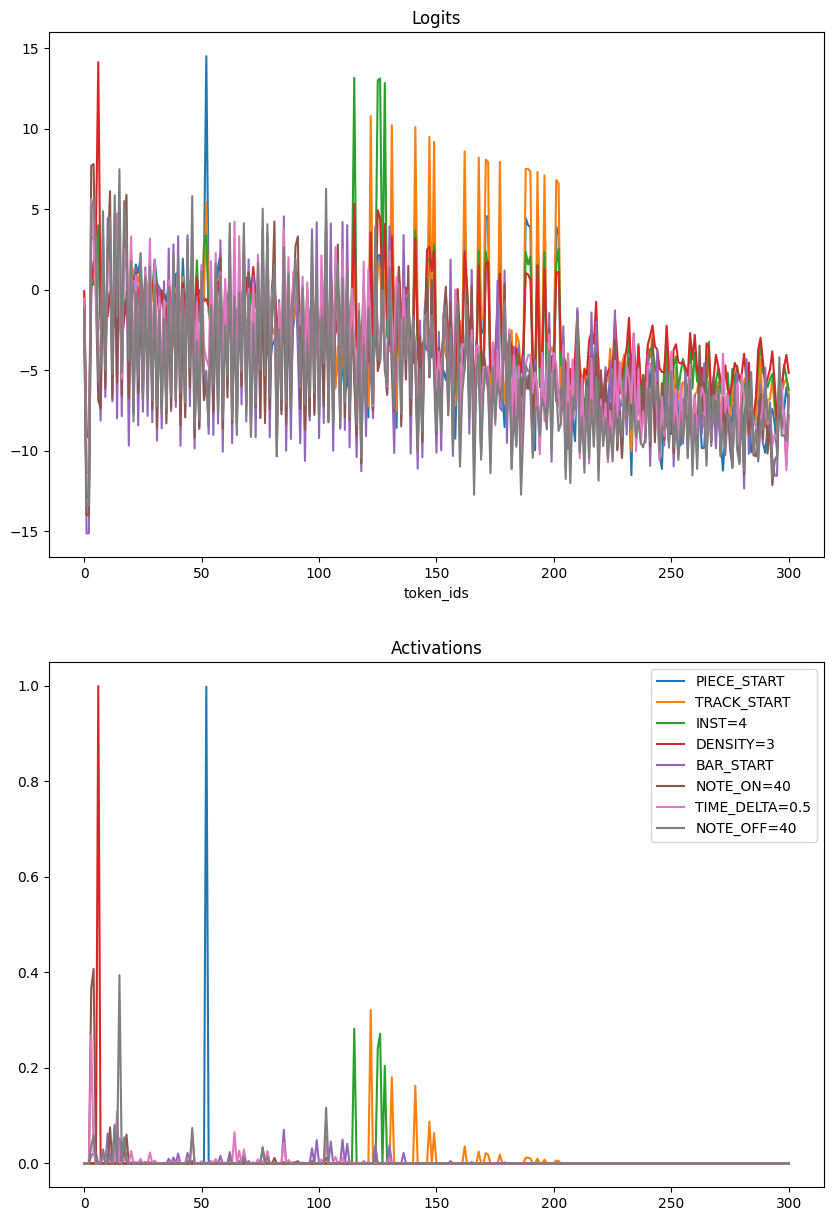

{'PIECE_START':      token_ids       tokens     logits  softmax_activations
 0           52  TRACK_START  14.502446         9.983468e-01
 1          122       INST=3   6.576822         3.607669e-04
 2          131   INST=DRUMS   6.288020         2.702723e-04
 3          141       INST=4   6.023459         2.074456e-04
 4          147       INST=0   5.705403         1.509295e-04
 ..         ...          ...        ...                  ...
 296        246  NOTE_ON=104 -11.118219         7.453622e-12
 297        272  NOTE_ON=113 -11.225033         6.698533e-12
 298        233  NOTE_OFF=15 -11.507551         5.049899e-12
 299          1        [PAD] -12.866877         1.296986e-12
 300          2       [MASK] -12.878598         1.281873e-12
 
 [301 rows x 4 columns],
 'TRACK_START':      token_ids       tokens     logits  softmax_activations
 0          122       INST=3  10.784713         3.215142e-01
 1          131   INST=DRUMS  10.205354         1.801307e-01
 2          141       INST=4

In [93]:
prompt = "PIECE_START TRACK_START INST=4 DENSITY=3 BAR_START NOTE_ON=40 TIME_DELTA=0.5 NOTE_OFF=40"
prompt_list = prompt.split(" ")
inputs = data_collator([tokenizer.encode(prompt)])
# inputs = [random.choice(data_tokenized)]
# inputs = data_collator(inputs)
outputs = model(**inputs)


activations = torch.nn.functional.softmax(outputs["logits"], dim=-1)
summary_k_tokens = {}
fig = plt.figure(figsize=(10,15))
for p, token in enumerate(prompt_list):
    logits = outputs["logits"].detach().numpy()[0][p]
    activation = activations.detach().numpy()[0][p]
    plt.subplot(2,1,1)
    plt.plot(logits, label=token)
    plt.xlabel("token_ids")
    plt.title("Logits")

    plt.subplot(2,1,2)
    plt.plot(activation, label=token)
    plt.title("Activations")

    # summarizing things into a pandas dataframe
    sorted_arg_tokens = logits.argsort()[::-1]
    sorted_logits = logits[sorted_arg_tokens]
    summary_k_tokens[token] = pd.DataFrame.from_dict(
        {
            "token_ids": sorted_arg_tokens, 
            "tokens": [tokenizer.decode(id) for id in sorted_arg_tokens],
            "logits": logits[sorted_arg_tokens], 
            "softmax_activations": activation[sorted_arg_tokens]
        }
    )
    

plt.subplot(2,1,1)
plt.subplot(2,1,2)
plt.legend()
plt.show()
plt.close()

summary_k_tokens

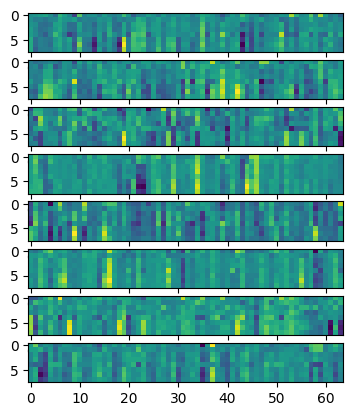

In [94]:
for i, pkv in enumerate(outputs["past_key_values"][0][0][0]):
    plt.subplot(len(outputs["past_key_values"][0][0][0]), 1, i+1)
    plt.imshow(pkv.detach().numpy())
# plt.imshow(outputs["past_key_values"][0][0][0][0].detach().numpy())
# print(outputs["past_key_values"][0][0][0].shape)
# # outputs["past_key_values"][0][0][0].shape
# # outputs["past_key_values"][0][0][0].shape
# # outputs["past_key_values"][0][0][0].shape

In [96]:
64*8


512

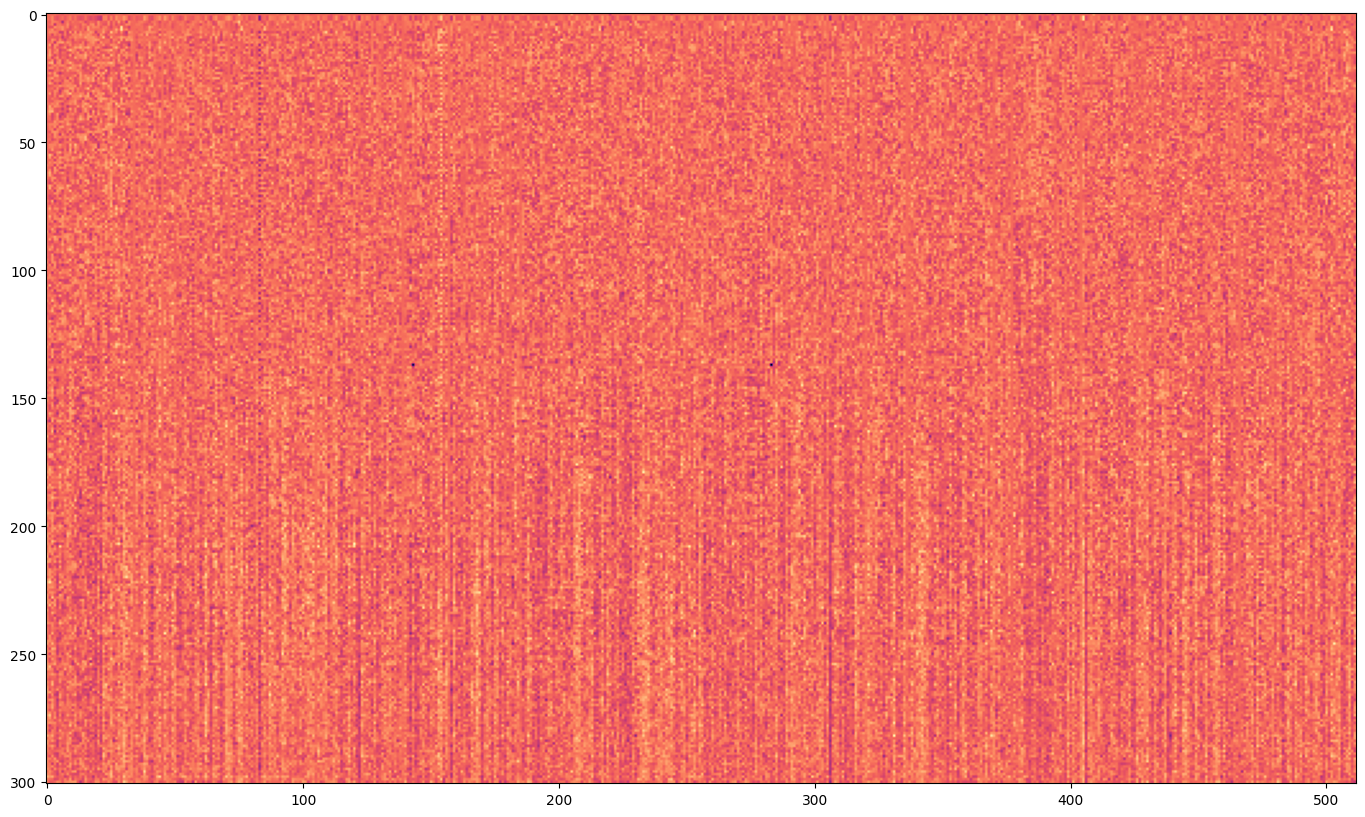

In [97]:
# picturing the embedding of a model ? is that it? 
fig = plt.figure(figsize=(20,10))
plt.imshow(
    model.get_input_embeddings().state_dict()["weight"].detach().numpy(), 
    cmap="magma"
)

In [ ]:

# make tsne plot of the embeddings
tsne = TSNE(n_components=2, random_state=0)
tsne_obj = tsne.fit_transform(model.get_input_embeddings().state_dict()["weight"].detach().numpy())
tsne_df = pd.DataFrame({'X':tsne_obj
[:,0], 'Y':tsne_obj[:,1], 'token':tokenizer.get_vocab().keys()})
tsne_df['token'] = tsne_df['token'].apply(lambda x: tokenizer.decode(x))
tsne_df.head()